In [ ]:
import numpy as np
from scipy.special import eval_hermite
import matplotlib.pyplot as plt
import random
import math
from scipy.optimize import curve_fit

In [ ]:
def exact_wavefunc(x, n):
    return eval_hermite(n, x) * np.exp(-x**2 / 2)

def exact_der(x, n):
    return (x**2 - 2*n - 1) * exact_wavefunc(x, n)

def cent_diff_2(x, n, h, func):
    '''
    h is the step size
    
    '''
    return (func(x+h, n) - 2 * func(x, n) + func(x-h, n)) / h**2

def cent_diff_4(x, n, h, func):
    return (-(func(x+2*h, n) + func(x-2*h, n)) + 
            16 * (func(x+h, n) + func(x-h, n)) - 
            30 * func(x, n)) / (12 * h**2)

def cent_diff_6(x,n,h, func):
    return (2 * (func(x+3*h, n) + func(x-3*h, n)) - 
            27 * (func(x+2*h, n) + func(x-2*h, n)) + 
            270 * (func(x+h, n) + func(x-h, n)) - 
            490 * func(x, n)) / (180 * h**2)

def cent_diff_8(x,n,h, func):
    return (-9 * (func(x+4*h, n) + func(x-4*h, n)) +
            128 * (func(x+3*h, n) + func(x-3*h, n)) - 
            1008 * (func(x+2*h, n) + func(x-2*h, n)) + 
            8064 * (func(x+h, n) + func(x-h, n)) - 
            14350 * func(x, n)) / (5040 * h**2)

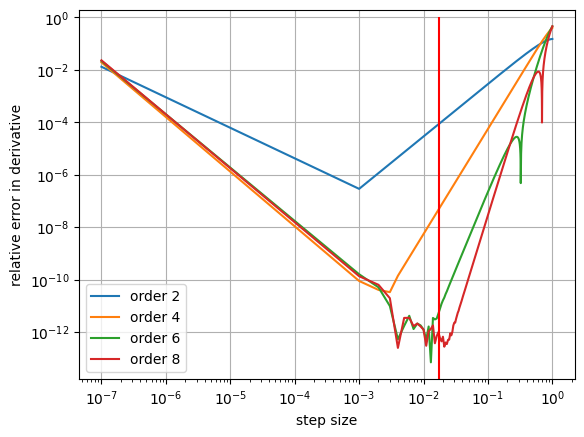

In [ ]:
schemes = [cent_diff_2, cent_diff_4, cent_diff_6, cent_diff_8]
x = 5
n = 7
h = np.linspace(1e-7, 1, 1000)
numerical_ders = []
for scheme in schemes:
    numerical_ders.append(scheme(x, n, h, exact_wavefunc)) 

j = 1
exact = exact_der(x, n)
for der in numerical_ders:
    plt.plot(h, abs((der - exact) / exact), label = f'order {2*j}')
    j+=1

plt.ylabel('relative error in derivative')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('step size')
plt.vlines(1.75e-2, 0, 1, colors= 'red')
plt.legend()
plt.grid()
plt.show()

In [ ]:
'''
After seeing graph, choosing 4th order difference scheme at h = 3e-3
'''

def get_blocking_error(data):
    n = len(data)
    var = np.var(data, ddof=1)
    errors = [np.sqrt(var/n)]
    while n >=4:
        n = n // 2
        blocked_data = np.mean(data[:n*2].reshape(-1, 2), axis=1)
        var_new = np.var(blocked_data, ddof=1)
        error_new = np.sqrt(var_new/n)
        errors.append(error_new)
        data = blocked_data
    return np.max(errors[:-4])  # Exclude the last few unreliable estimates

h_der = 3e-3
def generate_randoms(N_s, n, burn_in = 100):
    x_samples = np.zeros(N_s+burn_in)
    x_0 = 0.
    x = x_0
    for i in range(N_s + burn_in):
        random_step = (np.random.rand() - 0.5) * 3
        x_prime = x + random_step
        p_x = (exact_wavefunc(x, n))**2
        p_x_prime = (exact_wavefunc(x_prime, n))**2
        if p_x != 0.:
            p_acc = min(p_x_prime / p_x, 1.)
        else: p_acc = 1.

        rand = np.random.rand()
        if rand <= p_acc:
            x = x_prime
        x_samples[i] = x
    norm_const = np.sqrt(np.pi) * 2**n * math.factorial(n) #analytically derived
    x_uniform = np.linspace(np.min(x_samples[burn_in:]), np.max(x_samples[burn_in:]), 10000)
    probs = exact_wavefunc(x_uniform, n)**2 / norm_const
    return x_samples[burn_in:], x_uniform, probs

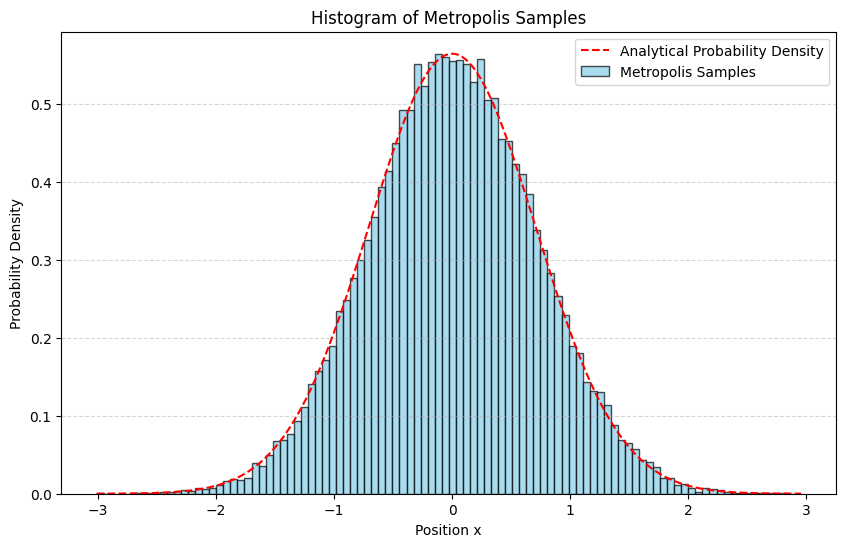

expected E is 0.4999999999990825, with standard deviation of 7.115266436724103e-14, difference between actual and expected is -9.174883075502294e-13


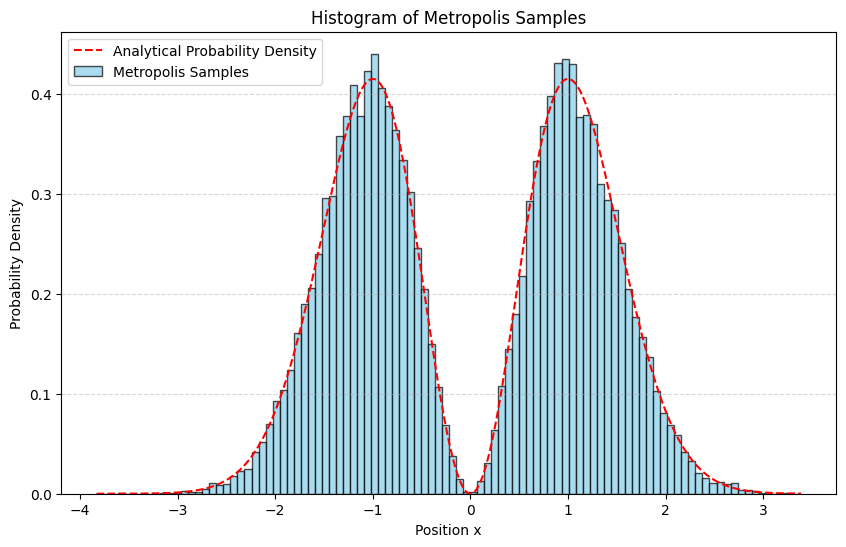

expected E is 1.4999999999940272, with standard deviation of 1.6531913338290316e-13, difference between actual and expected is -5.972777827878417e-12


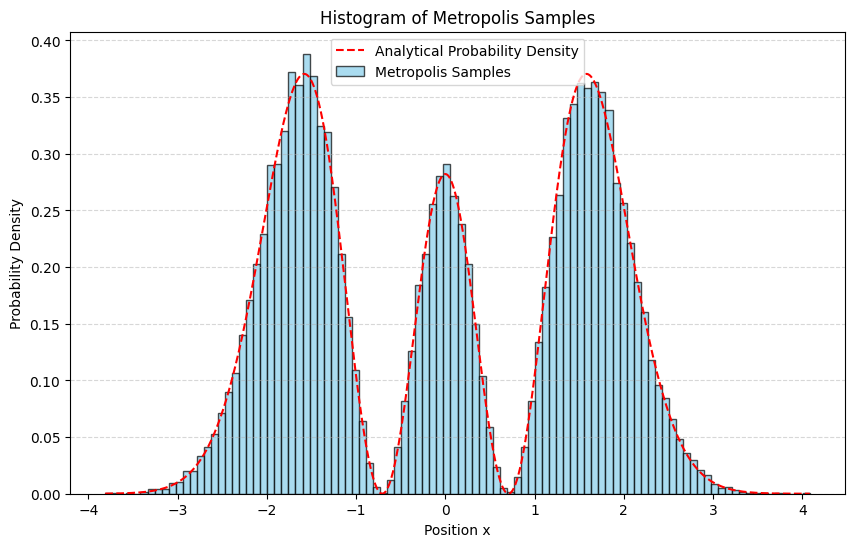

expected E is 2.4999999999788876, with standard deviation of 3.979967771218412e-13, difference between actual and expected is -2.1112445125481827e-11


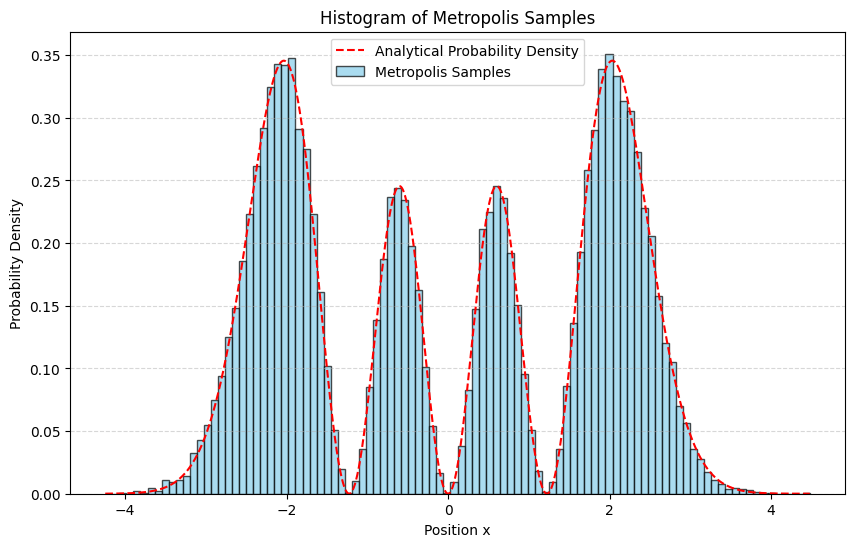

expected E is 3.499999999946328, with standard deviation of 8.339179997555674e-13, difference between actual and expected is -5.367217781326872e-11


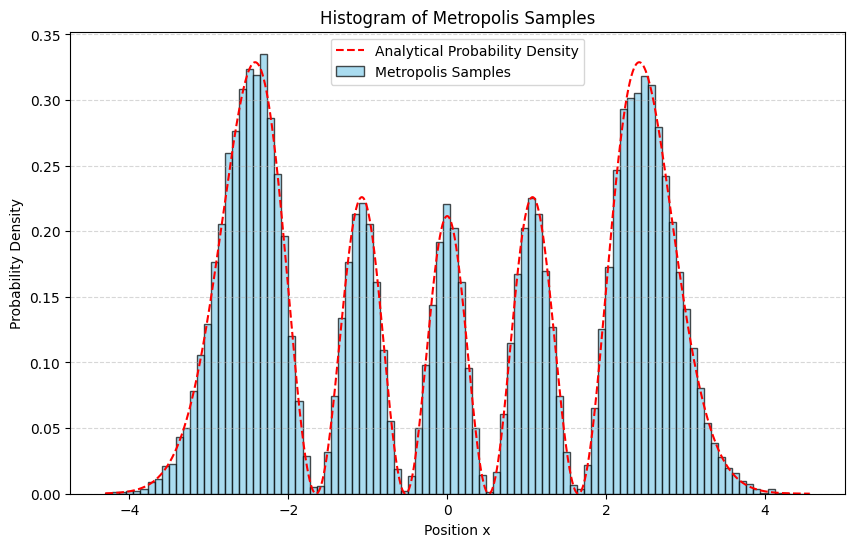

expected E is 4.499999999892032, with standard deviation of 1.5958233470856596e-12, difference between actual and expected is -1.0796785687716692e-10


In [ ]:
ns = np.arange(0,5)
SHO_energies = []
SHO_std = []
SHO_errors = []
for n in ns:
    x, x_uniform, probs = generate_randoms(100000, n)
    plt.figure(figsize=(10, 6))

    plt.hist(x, bins=100, density=True, color='skyblue', edgecolor='black', alpha=0.7)
    plt.plot(x_uniform, probs, '--',color = 'red')
    plt.grid(axis='y', alpha=0.5, linestyle='--')
    plt.xlabel('Position x')
    plt.ylabel('Probability Density')
    plt.title('Histogram of Metropolis Samples')
    plt.legend(['Analytical Probability Density', 'Metropolis Samples'])
    plt.show()
    local_energies = -0.5 * (1 / exact_wavefunc(x, n)) * cent_diff_4(x, n, h_der, exact_wavefunc) + 0.5 * x**2
    exp_E = np.mean(local_energies)
    SHO_energies.append(exp_E)
    std_E = get_blocking_error(local_energies)
    SHO_std.append(std_E)
    E_to_exp_diff = (exp_E - (n + 0.5))
    SHO_errors.append(E_to_exp_diff)

    print(f'expected E is {exp_E}, with standard deviation of {std_E}, difference between actual and expected is {E_to_exp_diff}')

In [ ]:
for n, E, err, diff in zip(ns, SHO_energies, SHO_std, SHO_errors):
    print(
        f"n = {n:2d}  "
        f"E_MC = {E: .6f} ± {err:.1e}  "
        f"exact = {n+0.5: .6f}  "
        f"ΔE = {diff:.1e}"
    )

n =  0  E_MC =  0.500000 ± 7.1e-14  exact =  0.500000  ΔE = -9.2e-13
n =  1  E_MC =  1.500000 ± 1.7e-13  exact =  1.500000  ΔE = -6.0e-12
n =  2  E_MC =  2.500000 ± 4.0e-13  exact =  2.500000  ΔE = -2.1e-11
n =  3  E_MC =  3.500000 ± 8.3e-13  exact =  3.500000  ΔE = -5.4e-11
n =  4  E_MC =  4.500000 ± 1.6e-12  exact =  4.500000  ΔE = -1.1e-10


In [ ]:
def r(x, y, z):
    return np.sqrt(x**2 + y**2 + z**2)
def hydrogen_wavefunc(theta, x, y, z):
    return np.exp(-theta * r(x,y,z))

def cent_diff_4_laplacian(x, y, z, func, theta, h):
    current_point = func(theta, x, y, z)
    der_x = (-(func(theta, x+2*h, y, z) + func(theta, x-2*h, y, z)) + 
            16 * (func(theta, x+h, y, z) + func(theta, x-h, y, z)) - 
            30 * current_point) / (12 * h**2)
    der_y = (-(func(theta, x, y+2*h, z) + func(theta, x, y-2*h, z)) + 
            16 * (func(theta, x, y+h, z) + func(theta, x, y-h, z)) - 
            30 * current_point) / (12 * h**2)
    der_z = (-(func(theta, x, y, z+2*h) + func(theta, x, y, z-2*h)) + 
            16 * (func(theta, x, y, z+h) + func(theta, x, y, z-h)) - 
            30 * current_point) / (12 * h**2)

    return der_x + der_y + der_z

def analytical_laplacian(theta, x, y, z):
    return (theta**2 - (2*theta / r(x,y,z))) * hydrogen_wavefunc(theta,x,y,z)

def local_energy_H_3D(theta, x, y, z):
    wf_value = hydrogen_wavefunc(theta, x, y, z)
    return (-0.5 * (cent_diff_4_laplacian(x,y,z,hydrogen_wavefunc,theta, h_der)/wf_value)) - 1/r(x,y,z)


def generate_randoms_3d(N_s, theta, burn_in = 100):
    pos_samples = np.zeros((N_s+burn_in, 3))
    pos_0 = np.array([1e-5,1e-5,1e-5])
    pos = pos_0
    for i in range(N_s + burn_in):
        random_x_step = (np.random.rand() - 0.5) * 2
        random_y_step = (np.random.rand() - 0.5) * 2
        random_z_step = (np.random.rand() - 0.5) * 2
        random_step = np.array([random_x_step, random_y_step, random_z_step])
        pos_prime = pos + random_step
        p_x = (hydrogen_wavefunc(theta, *pos))**2
        p_x_prime = (hydrogen_wavefunc(theta, *pos_prime))**2
        if p_x != 0.:
            p_acc = min(p_x_prime / p_x, 1.)
        else: p_acc = 1.

        rand = np.random.rand()
        if rand <= p_acc:
            pos = pos_prime
        pos_samples[i] = pos
    
    return pos_samples[burn_in:]

def generate_randoms_3d_single(n_walkers, steps, step_size, theta, r_0 = np.array([1e-5,1e-5,1e-5]), burn_in = 100):
    rng = np.random.default_rng()
    if r_0.ndim == 1:
        pos = np.tile(r_0, (n_walkers, 1))
    else:
        pos = r_0.copy()
    pos_samples = np.zeros((steps, n_walkers, 3))
    p_x = (hydrogen_wavefunc(theta, pos[:,0], pos[:,1], pos[:,2]))**2
    for i in range(steps + burn_in):
        random1_step = rng.normal(0, step_size, (n_walkers, 3))
        pos_prime = pos + random1_step
        p_x_prime = (hydrogen_wavefunc(theta, pos_prime[:,0], pos_prime[:,1], pos_prime[:,2]))**2
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = p_x_prime / p_x
            np.nan_to_num(ratio, copy=False, nan=0.0, posinf=1.0)
            p_acc = np.minimum(ratio, 1.0)

        rand = rng.random(n_walkers)
        accepted = rand <= p_acc
        pos[accepted] = pos_prime[accepted]
        p_x[accepted] = p_x_prime[accepted]
        if i >= burn_in:
            pos_samples[i - burn_in] = pos
    return pos_samples.reshape(-1, 3), pos_samples[-1]

theta = 3.0 
samples, _ = generate_randoms_3d_single(1000, 1000, 0.5, theta, np.array([1e-5,1e-5,1e-5]))

r_samples = np.sqrt(np.sum(samples**2, axis=1))

In [ ]:
'''
Numerical verification of Laplacian

'''
def test_laplacian(n_points = 1000, h=3e-3):
    max_diff = 0
    diffs = np.zeros(n_points)
    for i in range(n_points):
        rand_x, rand_y, rand_z = np.random.rand(), np.random.rand(), np.random.rand()
        theta_lap = np.random.rand() * 5
        numerical_laplacian = cent_diff_4_laplacian(rand_x, rand_y, rand_z, hydrogen_wavefunc, theta_lap, h)
        analyt_laplacian = analytical_laplacian(theta_lap, rand_x, rand_y, rand_z)
        diff = abs((numerical_laplacian - analyt_laplacian) / analyt_laplacian)
        diffs[i] = diff
        if diff > max_diff:
            max_diff = diff
    print(f"Max relative difference: {max_diff}, Mean relative difference: {np.mean(diffs)}, Median relative difference: {np.median(diffs)}, Std of relative differences: {np.std(diffs)}")
    return max_diff, np.mean(diffs), np.median(diffs), np.std(diffs)
test_laplacian()

Max relative difference: 1.5489116505546198e-06, Mean relative difference: 4.047613522661258e-09, Median relative difference: 2.5386232283737135e-10, Std of relative differences: 5.0160312936463706e-08


(np.float64(1.5489116505546198e-06),
 np.float64(4.047613522661258e-09),
 np.float64(2.5386232283737135e-10),
 np.float64(5.0160312936463706e-08))

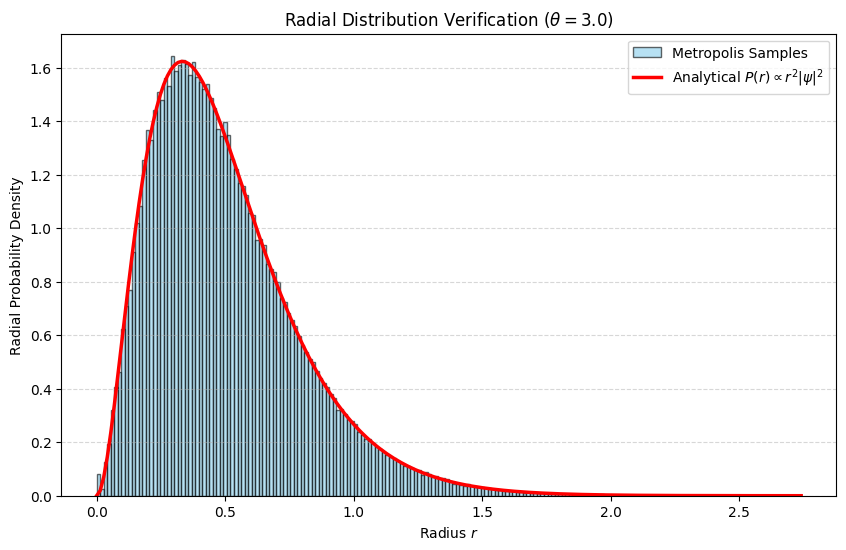

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(r_samples, bins=200, density=True, alpha=0.6, label='Metropolis Samples', color='skyblue', edgecolor='black')

r_plot = np.linspace(0, np.max(r_samples), 200)
analytical_curve = 4 * (theta**3) * (r_plot**2) * np.exp(-2 * theta * r_plot)

plt.plot(r_plot, analytical_curve, 'r-', linewidth=2.5, label=r'Analytical $P(r) \propto r^2 |\psi|^2$')

plt.xlabel('Radius $r$')
plt.ylabel('Radial Probability Density')
plt.title(f'Radial Distribution Verification ($\\theta={theta}$)')
plt.legend()
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()


#def E_exp_der(N_s)

In [ ]:
def der_H_theta(exp_E, energies, samples):
    r_samples = np.sqrt(np.sum(samples**2, axis = 1))
    differences = energies - exp_E
    return 2 * np.mean(-r_samples * differences)

def iterate_theta(theta, alpha, exp_E, energies, samples):
    new_theta = theta - alpha * der_H_theta(exp_E, energies, samples)
    return new_theta

def optimise_theta(walkers, steps, convergence_ratio, theta_0, max_runs, alpha):
    theta = theta_0
    thetas = []
    runs = 0
    theta_change_ratio = 100
    final_pos = np.array([1e-5,1e-5,1e-5])
    while theta_change_ratio > convergence_ratio and runs<= max_runs:
        samples, final_pos = generate_randoms_3d_single(walkers, steps, 0.5, theta, final_pos)
        x_vals = samples[:, 0]
        y_vals = samples[:, 1]
        z_vals = samples[:, 2]
        energies = local_energy_H_3D(theta, x_vals, y_vals, z_vals)
        exp_E_H = np.mean(energies)
        theta_prime = iterate_theta(theta, alpha, exp_E_H, energies, samples)
        theta_change_ratio = abs((theta - theta_prime) / theta)
        theta = theta_prime
        thetas.append(theta)
        runs += 1
    final_samples, _ = generate_randoms_3d_single(walkers, steps, 0.5, theta, final_pos)
    final_x_vals = final_samples[:, 0]
    final_y_vals = final_samples[:, 1]
    final_z_vals = final_samples[:, 2]
    final_energies = local_energy_H_3D(theta, final_x_vals, final_y_vals, final_z_vals)
    final_E_exp = np.mean(final_energies)
    return theta, final_E_exp, runs, thetas, final_x_vals, final_y_vals, final_z_vals, final_pos

In [ ]:
'''
alphas = np.linspace(0.05, 2.1, 100)
runs_list = []
for alpha in alphas:
    try:
        theta, final_E_exp, runs_val, thetas, final_x_vals, final_y_vals, final_z_vals = optimise_theta(1000, 1e-9, 2., 1000, alpha)
        runs_list.append(runs_val)
        print(f'For alpha = {alpha}, theta converged to {theta} in {runs_val} runs with expected energy of {final_E_exp}')
    except Exception as e:
        print(f'Optimization failed for alpha = {alpha} with error: {e}')
'''

"\nalphas = np.linspace(0.05, 2.1, 100)\nruns_list = []\nfor alpha in alphas:\n    try:\n        theta, final_E_exp, runs_val, thetas, final_x_vals, final_y_vals, final_z_vals = optimise_theta(1000, 1e-9, 2., 1000, alpha)\n        runs_list.append(runs_val)\n        print(f'For alpha = {alpha}, theta converged to {theta} in {runs_val} runs with expected energy of {final_E_exp}')\n    except Exception as e:\n        print(f'Optimization failed for alpha = {alpha} with error: {e}')\n"

0.999999919108052 -0.4999998363048225 427


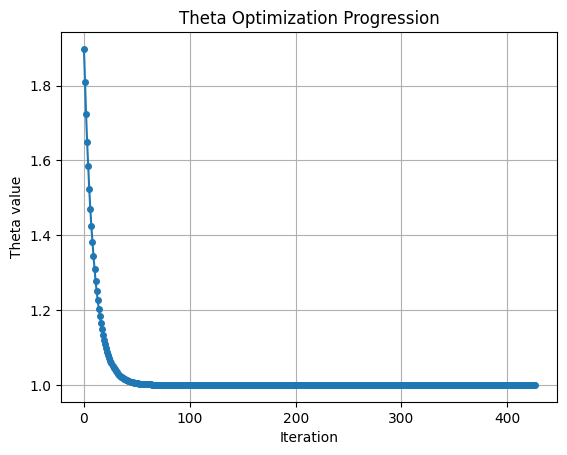

In [ ]:
theta, final_E_exp, runs, thetas, final_x_vals, final_y_vals, final_z_vals, final_pos = optimise_theta(100, 1000, 1e-9, 2., 1000, 0.1)
print(theta, final_E_exp, runs)
plt.plot(range(len(thetas)), thetas, 'o-', markersize=4)
plt.xlabel('Iteration')
plt.ylabel('Theta value')
plt.title('Theta Optimization Progression')
plt.grid()
plt.show()

In [ ]:
'''
plt.plot(alphas, runs_list, 'o-', markersize=4)
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('Number of Iterations to Converge')
plt.title('Effect of Learning Rate on Convergence Speed')
plt.grid()
plt.show()
'''
E_single = final_E_exp

In [ ]:
random_proof_samples, _ = generate_randoms_3d_single(100, 100000, 0.5, theta, final_pos)
final_x_vals = random_proof_samples[:, 0]
final_y_vals = random_proof_samples[:, 1]
final_z_vals = random_proof_samples[:, 2]

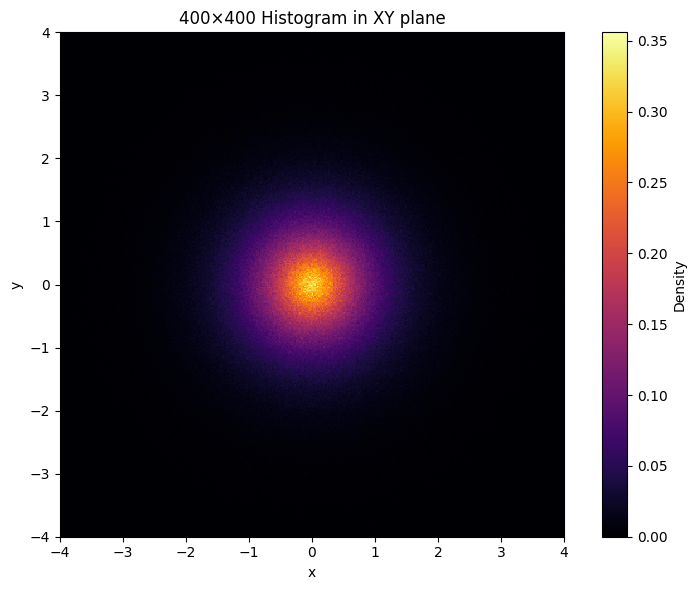

In [ ]:
plt.figure(figsize=(8, 6))

hist = plt.hist2d(
    final_x_vals,
    final_y_vals,
    bins=(400, 400),
    density=True,
    cmap=plt.cm.inferno,
    range=[[-4, 4], [-4, 4]]  # optional, but usually nice to fix
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('400×400 Histogram in XY plane')
plt.gca().set_aspect('equal', adjustable='box')

cbar = plt.colorbar(label='Density')

plt.tight_layout()
plt.show()

In [ ]:
def r_vector(array):
    if array.ndim == 1:
        return np.sqrt(np.sum(array**2))
    return np.sqrt(np.sum(array**2, axis=1))

def h_molecule_wavefunc(theta, q1, q2, r1, r2):
    psi = (np.exp(-theta[0] * (r_vector(r1-q1) + r_vector(r2-q2))) + 
           np.exp(-theta[0] * (r_vector(r1-q2) + r_vector(r2-q1)))) * np.exp(-(theta[1]) / (1+theta[2]*r_vector(r1-r2)))
    return psi
def generate_randoms_3d_2particles(N_s, theta, q1, q2, r1_0 = np.array([1e-5,1e-5,1e-5]), r2_0 = -np.array([1e-5,1e-5,1e-5]), burn_in = 100):
    rng = np.random.default_rng()
    pos1_samples = np.zeros((N_s+burn_in, 3)) 
    pos2_samples = np.zeros((N_s+burn_in, 3))
    pos1_0 = r1_0
    pos2_0 = r2_0
    pos1 = pos1_0
    pos2 = pos2_0
    for i in range(N_s + burn_in):
        random1_step = rng.normal(0, 1, 3)
        pos1_prime = pos1 + random1_step

        random2_step = rng.normal(0, 1, 3)
        pos2_prime = pos2 + random2_step

        p_x = (h_molecule_wavefunc(theta, q1, q2, pos1, pos2))**2
        p_x_prime = (h_molecule_wavefunc(theta, q1, q2, pos1_prime, pos2_prime))**2
        if p_x != 0.:
            p_acc = min(p_x_prime / p_x, 1.)
        else: p_acc = 1.

        rand = np.random.rand()
        if rand <= p_acc:
            pos1 = pos1_prime
            pos2 = pos2_prime
        pos1_samples[i] = pos1
        pos2_samples[i] = pos2
    return pos1_samples[burn_in:], pos2_samples[burn_in:], pos1_samples[-1], pos2_samples[-1]

def generate_randoms_3d_vectorised(n_walkers, steps, step_size, theta, q1, q2, r1_0 = np.array([1e-5,1e-5,1e-5]), r2_0 = -np.array([1e-5,1e-5,1e-5]), burn_in = 100):
    rng = np.random.default_rng()
    if r1_0.ndim == 1:
        pos1 = np.tile(r1_0, (n_walkers, 1))
        pos2 = np.tile(r2_0, (n_walkers, 1))
    else:
        pos1 = r1_0.copy()
        pos2 = r2_0.copy()
    pos1_samples = np.zeros((steps, n_walkers, 3))
    pos2_samples = np.zeros((steps, n_walkers, 3))
    p_x = (h_molecule_wavefunc(theta, q1, q2, pos1, pos2))**2
    for i in range(steps + burn_in):
        random1_step = rng.normal(0, step_size, (n_walkers, 3))
        pos1_prime = pos1 + random1_step

        random2_step = rng.normal(0, step_size, (n_walkers, 3))
        pos2_prime = pos2 + random2_step
        p_x_prime = (h_molecule_wavefunc(theta, q1, q2, pos1_prime, pos2_prime))**2
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = p_x_prime / p_x
            np.nan_to_num(ratio, copy=False, nan=0.0, posinf=1.0)
            p_acc = np.minimum(ratio, 1.0)

        rand = rng.random(n_walkers)
        accepted = rand <= p_acc
        pos1[accepted] = pos1_prime[accepted]
        pos2[accepted] = pos2_prime[accepted]
        p_x[accepted] = p_x_prime[accepted]
        if i >= burn_in:
            pos1_samples[i - burn_in] = pos1
            pos2_samples[i - burn_in] = pos2
    return pos1_samples.reshape(-1, 3), pos2_samples.reshape(-1, 3), pos1_samples[-1], pos2_samples[-1]


def cent_diff_4_laplacian_H2(theta, q1, q2, r1, r2, func, h=1e-5):
    x_diff_h = np.array([h,0,0])
    y_diff_h = np.array([0,h,0])
    z_diff_h = np.array([0,0,h])

    x_diff_2h = np.array([2*h,0,0])
    y_diff_2h = np.array([0,2*h,0])
    z_diff_2h = np.array([0,0,2*h])

    current_point = func(theta, q1, q2, r1, r2)
    #loop for r1
    der_r1_x = (-(func(theta, q1, q2, r1 + x_diff_2h, r2) + func(theta, q1, q2, r1 - x_diff_2h, r2)) + 
            16 * (func(theta, q1, q2, r1 + x_diff_h, r2) + func(theta, q1, q2, r1 - x_diff_h, r2)) - 
            30 * current_point) / (12 * h**2)
    der_r1_y = (-(func(theta, q1, q2, r1 + y_diff_2h, r2) + func(theta, q1, q2, r1 - y_diff_2h, r2)) + 
            16 * (func(theta, q1, q2, r1 + y_diff_h, r2) + func(theta, q1, q2, r1 - y_diff_h, r2)) - 
            30 * current_point) / (12 * h**2)
    der_r1_z = (-(func(theta, q1, q2, r1 + z_diff_2h, r2) + func(theta, q1, q2, r1 - z_diff_2h, r2)) + 
            16 * (func(theta, q1, q2, r1 + z_diff_h, r2) + func(theta, q1, q2, r1 - z_diff_h, r2)) - 
            30 * current_point) / (12 * h**2)
    #loop for r2
    der_r2_x = (-(func(theta, q1, q2, r1, r2 + x_diff_2h) + func(theta, q1, q2, r1, r2 - x_diff_2h)) + 
            16 * (func(theta, q1, q2, r1, r2 + x_diff_h) + func(theta, q1, q2, r1, r2 - x_diff_h)) - 
            30 * current_point) / (12 * h**2)
    der_r2_y = (-(func(theta, q1, q2, r1, r2 + y_diff_2h) + func(theta, q1, q2, r1, r2 - y_diff_2h)) + 
            16 * (func(theta, q1, q2, r1, r2 + y_diff_h) + func(theta, q1, q2, r1, r2 - y_diff_h)) - 
            30 * current_point) / (12 * h**2)
    der_r2_z = (-(func(theta, q1, q2, r1, r2 + z_diff_2h) + func(theta, q1, q2, r1, r2 - z_diff_2h)) + 
            16 * (func(theta, q1, q2, r1, r2 + z_diff_h) + func(theta, q1, q2, r1, r2 - z_diff_h)) -
            30 * current_point) / (12 * h**2)
    return der_r1_x + der_r1_y + der_r1_z + der_r2_x + der_r2_y + der_r2_z

def cent_diff_2_laplacian_H2(theta, q1, q2, r1, r2, func, h=1e-5):
    x_diff_h = np.array([h,0,0])
    y_diff_h = np.array([0,h,0])
    z_diff_h = np.array([0,0,h])

    #x_diff_2h = np.array([2*h,0,0])
    #y_diff_2h = np.array([0,2*h,0])
    #z_diff_2h = np.array([0,0,2*h])

    current_point = func(theta, q1, q2, r1, r2)
    #loop for r1
    der_r1_x =   (func(theta, q1, q2, r1 + x_diff_h, r2) + func(theta, q1, q2, r1 - x_diff_h, r2) - 
                  2 * current_point) / (h**2)
    der_r1_y = (func(theta, q1, q2, r1 + y_diff_h, r2) + func(theta, q1, q2, r1 - y_diff_h, r2) - 
                  2 * current_point) / (h**2)
    der_r1_z = (func(theta, q1, q2, r1 + z_diff_h, r2) + func(theta, q1, q2, r1 - z_diff_h, r2) - 
                  2 * current_point) / (h**2)
    #loop for r2
    der_r2_x = (func(theta, q1, q2, r1, r2 + x_diff_h) + func(theta, q1, q2, r1, r2 - x_diff_h) - 
                  2 * current_point) / (h**2)
    der_r2_y = (func(theta, q1, q2, r1, r2 + y_diff_h) + func(theta, q1, q2, r1, r2 - y_diff_h) - 
                  2 * current_point) / (h**2)
    der_r2_z = (func(theta, q1, q2, r1, r2 + z_diff_h) + func(theta, q1, q2, r1, r2 - z_diff_h) -
            2 * current_point) / (h**2)
    return der_r1_x + der_r1_y + der_r1_z + der_r2_x + der_r2_y + der_r2_z

def local_energy_H2(theta, q1, q2, r1, r2):
    wf_value = h_molecule_wavefunc(theta, q1, q2, r1, r2)
    kinetic = -0.5 * cent_diff_2_laplacian_H2(theta, q1, q2, r1, r2, h_molecule_wavefunc) / wf_value
    potential = -(1/r_vector(r1-q1) + 1/r_vector(r1-q2) + 
                  1/r_vector(r2-q1) + 1/r_vector(r2-q2)) + (1/r_vector(r1 - r2) + 1/np.linalg.norm(q1 - q2))
    return kinetic + potential

In [ ]:
def der_H2_theta(theta, q1, q2, r1, r2, energies, E_exp):
    N_s = energies.shape[0]
    dphitheta = np.zeros((3, N_s))
    wf_value = h_molecule_wavefunc(theta, q1, q2, r1, r2)
    r1q1 = abs(r_vector(r1 - q1))
    r1q2 = abs(r_vector(r1 - q2))
    r2q1 = abs(r_vector(r2 - q1))
    r2q2 = abs(r_vector(r2 - q2))
    r2r1 = abs(r_vector(r2 - r1))
    non_cross = r1q1+r2q2
    cross = r1q2 + r2q1
    #Analytically found derivative wrt theta[0]
    part_der_0 = (-non_cross * np.exp(-theta[0] * non_cross) - cross * np.exp(-theta[0] * cross)) * np.exp(-(theta[1])/(1+theta[2]*r2r1))
    #Analytically found derivative wrt theta[1]
    part_der_1 = (-1/(1 + theta[2] * r2r1)) * wf_value
    #Analytically found derivative wrt theta[2]
    part_der_2 = ((r2r1 * theta[1]) / (1 + theta[2]*r2r1)**2) * wf_value

    dphitheta[0] = part_der_0
    dphitheta[1] = part_der_1
    dphitheta[2] = part_der_2

    grad_exp = ((energies - E_exp) * (dphitheta/wf_value))
    return 2 * np.mean(grad_exp, axis=1)

def iterate_theta_H2(theta, q1, q2, r1, r2, alpha, exp_E, energies):
    new_theta = theta - alpha * der_H2_theta(theta, q1, q2, r1, r2, energies, exp_E)
    return new_theta

def optimise_theta_H2(N_s, steps, convergence_ratio, theta_0, max_runs, alpha, q1, q2, minruns = 25):
    theta = theta_0
    thetas = []
    runs = 0
    theta_change_ratio = 100
    while (theta_change_ratio > convergence_ratio and  runs <= max_runs) or runs < minruns:
        if runs == 0:
            r1_samples, r2_samples, last_r1, last_r2 = generate_randoms_3d_vectorised(N_s, steps, 0.5, theta, q1, q2)
        else:
            r1_samples, r2_samples, last_r1, last_r2 = generate_randoms_3d_vectorised(N_s, steps, 0.5, theta, q1, q2, last_r1, last_r2)
        energies = local_energy_H2(theta, q1, q2, r1_samples, r2_samples)
        exp_E_H = np.mean(energies)
        theta_prime = iterate_theta_H2(theta, q1, q2, r1_samples, r2_samples, alpha, exp_E_H, energies)
        theta_change_ratio = np.max(abs((theta - theta_prime) / theta))
        theta = theta_prime
        thetas.append(theta)
        runs += 1
        print(runs)
    final_r1_samples, final_r2_samples, last_r1, last_r2 = generate_randoms_3d_vectorised(N_s, 10000, 0.5, theta, q1, q2, last_r1, last_r2)
    final_energies = local_energy_H2(theta, q1, q2, final_r1_samples, final_r2_samples)
    error = get_blocking_error(final_energies)
    final_E_exp = np.mean(final_energies)

    return theta, final_E_exp, runs, thetas, final_r1_samples, final_r2_samples, error

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
For nuclear separation of [0.5 0.  0. ], theta converged to [1.46265048 0.95652366 1.00443842] in 172 runs with expected energy of -0.49258247042523 Hartree
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
For nuclear separation of [0.64583333 0.         0.        ], theta converged to [1.47393714 0.95179308 1.0040078 ] in 26 runs with expected energy of -0.8221100299655111 Hartree
1
2
3
4
5
6
7
8

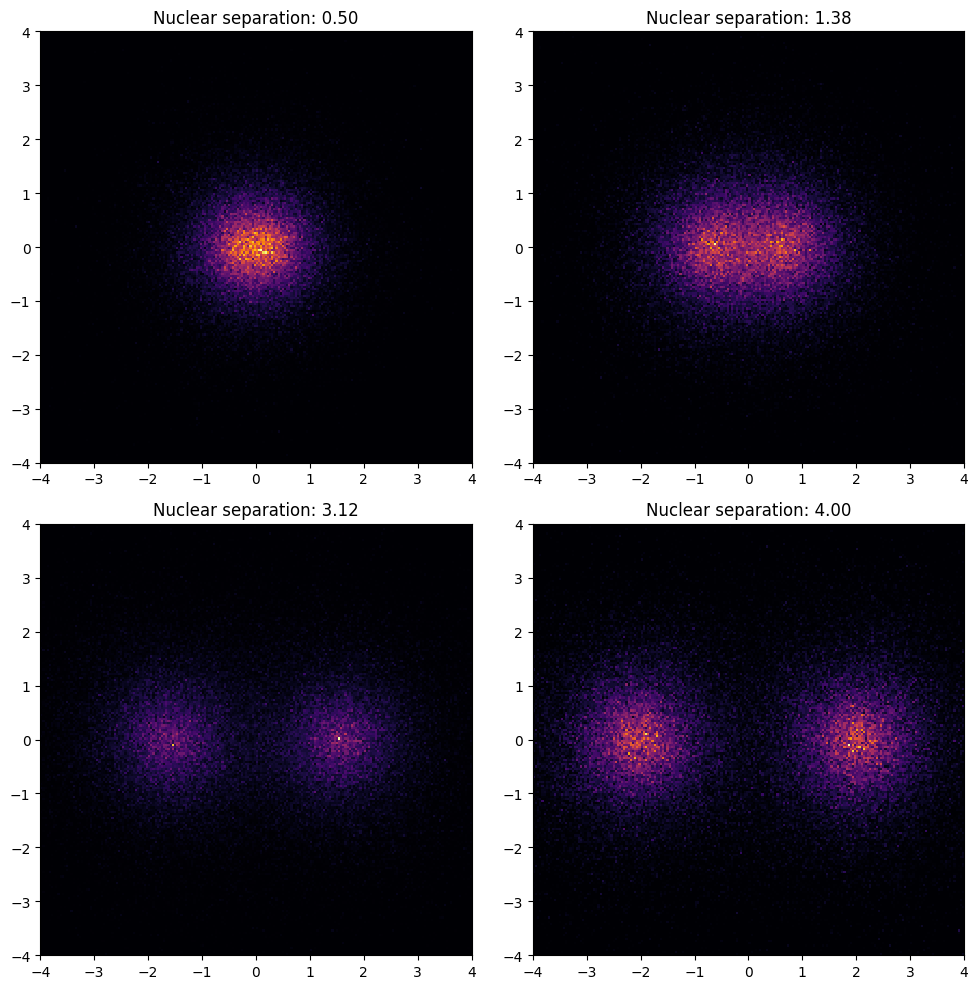

In [ ]:
qs = np.linspace(0.25, 2.0, 25)
n_qs = len(qs)
indices_to_plot = [0, n_qs // 4, 3 * n_qs // 4, n_qs - 1]
stored_plots = []
energies = []
errors = []
nuclear_separations = []
Ns = 10
theta_0 = [1.,1.,1.]
alpha = 0.005
for index, q in enumerate(qs):
    q1, q2 = np.array([q, 0., 0.]), np.array([-q, 0., 0.])
    theta, E_exp, runs, thetas, final_r1_samples, final_r2_samples, error = optimise_theta_H2(Ns, 100, 1e-4, theta_0, 1000, alpha, q1, q2)
    energies.append(E_exp)
    errors.append(error)
    nuclear_separations.append(2*q)
    theta_0 = theta  # Use the converged theta as the starting point for the next separation
    print(f'For nuclear separation of {abs(q1 - q2)}, theta converged to {theta} in {runs} runs with expected energy of {E_exp} Hartree')
    
    if index in indices_to_plot:
        all_samples = np.vstack((final_r1_samples, final_r2_samples))
        stored_plots.append((2*q, all_samples[:, 0], all_samples[:, 1]))

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i, (sep, x, y) in enumerate(stored_plots):
    axs[i].hist2d(x, y, bins=200, density=True, cmap=plt.cm.inferno, range=[[-4, 4], [-4, 4]])
    axs[i].set_title(f'Nuclear separation: {sep:.2f}')
    axs[i].set_xlim(-4,4)
    axs[i].set_ylim(-4,4)
    axs[i].set_aspect('equal')

plt.tight_layout()
plt.show()

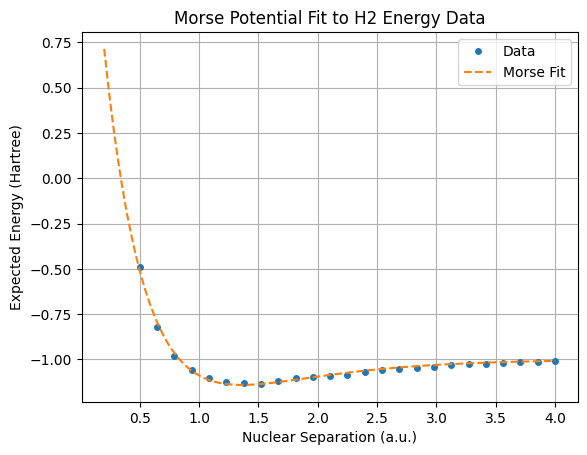

Fitted Morse Potential Parameters: D = 0.14104090269001035, a = 1.322024222666582, r0 = 1.3587715990285036
0.0026817249307155345 0.002589435678693404


In [ ]:
def morse(r, D, a, r0):
    return D * (1 - np.exp(-a * (r - r0)))**2 - D + 2*E_single

# Fit Morse potential to data
def fit_morse(nuclear_separations, energies):
    popt, pcov = curve_fit(morse, nuclear_separations, energies, p0=[0.2, 1.0, 1.4])
    D_fit, a_fit, r0_fit = popt
    r_fit = np.linspace(0.2, 4.0, 100)
    E_fit = morse(r_fit, D_fit, a_fit, r0_fit)
    plt.plot(nuclear_separations, energies, 'o', label='Data', markersize=4)
    plt.plot(r_fit, E_fit, '--', label='Morse Fit')
    plt.xlabel('Nuclear Separation (a.u.)')
    plt.ylabel('Expected Energy (Hartree)')
    plt.title('Morse Potential Fit to H2 Energy Data')
    #plt.axhline(y=-1.174, color='r', linestyle='--', label='Target (-1.174 Hartree)')
    plt.grid()
    plt.legend()
    plt.show()
    print(f'Fitted Morse Potential Parameters: D = {D_fit}, a = {a_fit}, r0 = {r0_fit}')
    print(np.mean(errors), np.median(errors))
fit_morse(nuclear_separations, energies)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
For nuclear separati

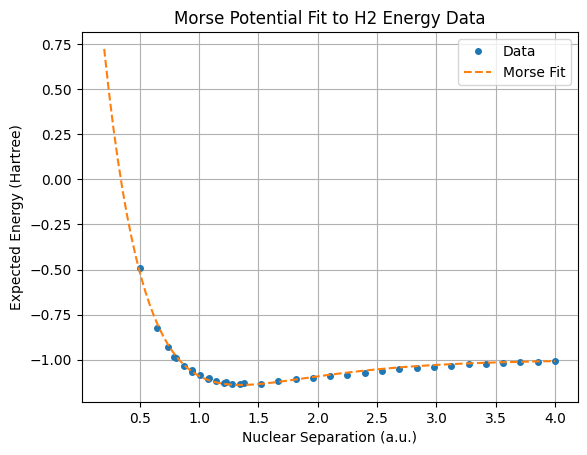

Fitted Morse Potential Parameters: D = 0.1399058474417774, a = 1.337596019170963, r0 = 1.3488329676686073
0.0025840560767465305 0.0023556362346157694


In [ ]:
qs_near_min = np.linspace(r0_fit-0.3, r0_fit+0.3, 10)
n_qs_near = len(qs_near_min)
indices_to_plot_near = [0, n_qs_near // 4, 3 * n_qs_near // 4, n_qs_near - 1]
stored_plots_near = []
Ns = 30
theta_0 = [1.,1.,1.]
alpha = 0.005
for index, q in enumerate(qs_near_min):
    q1, q2 = np.array([q/2, 0., 0.]), np.array([-q/2, 0., 0.])
    theta, E_exp, runs, thetas, final_r1_samples, final_r2_samples, error = optimise_theta_H2(Ns, 200, 1e-4, theta_0, 1000, alpha, q1, q2)
    energies.append(E_exp)
    errors.append(error)
    nuclear_separations.append(q)
    theta_0 = theta  # Use the converged theta as the starting point for the next separation
    print(f'For nuclear separation of {abs(q1 - q2)}, theta converged to {theta} in {runs} runs with expected energy of {E_exp} Hartree')
    
    if index in indices_to_plot_near:
        all_samples = np.vstack((final_r1_samples, final_r2_samples))
        stored_plots_near.append((q, all_samples[:, 0], all_samples[:, 1]))
fit_morse(nuclear_separations, energies)

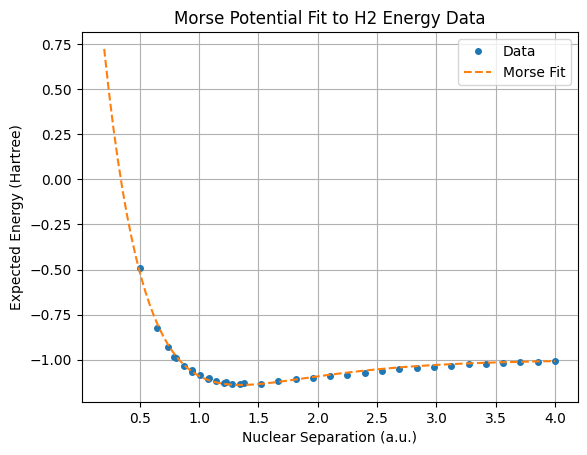

Fitted Morse Potential Parameters: D = 0.1399058474417774, a = 1.337596019170963, r0 = 1.3488329676686073
mean relative error in E is 0.0025840560767465305, median relative error in E is 0.0023556362346157694


In [ ]:
def morse(r, D, a, r0):
    return D * (1 - np.exp(-a * (r - r0)))**2 - D + 2*E_single

# Fit Morse potential to data
def fit_morse(nuclear_separations, energies):
    popt, pcov = curve_fit(morse, nuclear_separations, energies, p0=[0.2, 1.0, 1.4])
    D_fit, a_fit, r0_fit = popt
    r_fit = np.linspace(0.2, 4.0, 100)
    E_fit = morse(r_fit, D_fit, a_fit, r0_fit)
    plt.plot(nuclear_separations, energies, 'o', label='Data', markersize=4)
    plt.plot(r_fit, E_fit, '--', label='Morse Fit')
    plt.xlabel('Nuclear Separation (a.u.)')
    plt.ylabel('Expected Energy (Hartree)')
    plt.title('Morse Potential Fit to H2 Energy Data')
    #plt.axhline(y=-1.174, color='r', linestyle='--', label='Target (-1.174 Hartree)')
    plt.grid()
    plt.legend()
    plt.show()
    print(f'Fitted Morse Potential Parameters: D = {D_fit}, a = {a_fit}, r0 = {r0_fit}')
    print(f"mean relative error in E is {np.mean(errors)}, median relative error in E is {np.median(errors)}")
fit_morse(nuclear_separations, energies)